In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotel-booking-demand/hotel_bookings.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from time import strptime
sns.set_palette("Pastel1")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('../input/hotel-booking-demand/hotel_bookings.csv')

# **Let's look into the dataset**

In [4]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
df.shape

(119390, 32)

# **Let's start with our data cleaning**

**Checking for null values**

In [7]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
#copying the original dataframe
df1 = df.copy()
#I will drop the company  column due to the high amount of missing value
df1 =  df1.drop(columns='company')
#I will fill the na value in children with 0 
df1['children'] = df1['children'].fillna(0)
#I will fill the navalues in agent with 0
df1['agent'] = df1['agent'].fillna(0)


In [9]:
#we also notice children is showing as a float, we will change to int to match adults and babies
df1['children'] = df1['children'].astype(int)

In [10]:
#looking at the data source, we will amend meal types to make it clearer
meal_types = df1['meal'].unique().tolist()
print(meal_types)
meal_types_full = ['Bed & Breakfast', 'Full Board', 'Half Board', 'No Meal', 'No Meal']
df1['meal'].replace (meal_types, meal_types_full, inplace=True)
print(df1['meal'].unique())

['BB', 'FB', 'HB', 'SC', 'Undefined']
['Bed & Breakfast' 'Full Board' 'Half Board' 'No Meal']


In [11]:
#clarifying column name 
df1.rename(columns = {'adr': 'Average Daily Rate'}, inplace = True)

In [12]:
df1['reservation_status_date'] = pd.to_datetime(df1['reservation_status_date'])

In [13]:
#looking at duplicates and deleting them
print(f'There is {df1.duplicated().sum()} duplicated rows')

df1 = df1.drop_duplicates()

There is 32001 duplicated rows


In [14]:
#We will combine stays in weekend and stays in  weekdays to know the total amount of days

df1['total_nights'] = df1['stays_in_weekend_nights'] + df1['stays_in_week_nights']

In [15]:
# convert month to a number and create an arrival date combining columns 
df1['arrival_month'] = [strptime(str(x), '%B').tm_mon for x in df1['arrival_date_month']]
df1['arrival_date'] = pd.to_datetime(dict(year=df1['arrival_date_year'], month=df1['arrival_month'], day=df['arrival_date_day_of_month']))
df1

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,Average Daily Rate,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_nights,arrival_month,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Transient,0.00,0,0,Check-Out,2015-07-01,0,7,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Transient,0.00,0,0,Check-Out,2015-07-01,0,7,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,7,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,7,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,Transient,98.00,0,1,Check-Out,2015-07-03,2,7,2015-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,8,2017-08-30
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,8,2017-08-31
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,8,2017-08-31
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,8,2017-08-31


In [16]:
# Dropping unnecessart columns
columns_to_drop = ['arrival_date_year', 'arrival_date_month',
                   'arrival_date_day_of_month','arrival_date_week_number','arrival_month']
df1 =  df1.drop(columns=columns_to_drop)

# **Time to explore our data**

In [17]:
df1.describe()

In [18]:
df1['adults'].unique()

array([ 2,  1,  3,  4, 40, 26, 50, 27, 55,  0, 20,  6,  5, 10])

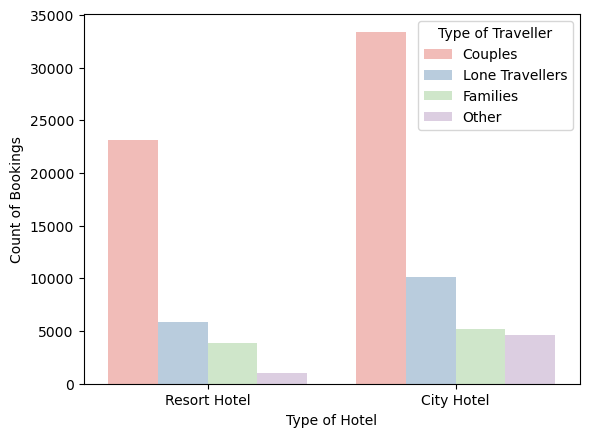

In [19]:
#we notice there are only two hotel types, resort and city
#we would like to explore and see if a certain type of hotel attracts more lone travellers / family 
hotel_type = list(df1['hotel'].unique())
conditions = [
    (df1['adults'] == 1) & (df1['children'] == 0) & (df1['babies'] == 0),
    (df1['adults'] == 2) & (df1['children'] == 0) & (df1['babies'] == 0),
    (df1['children'] > 0) | (df1['babies'] > 0)
]
values = ['Lone Travellers', 'Couples', 'Families']

df1['traveller_type'] = np.select(conditions, values)
sns.countplot(data=df1, x='hotel', hue='traveller_type')
plt.xlabel('Type of Hotel')
plt.ylabel('Count of Bookings')
plt.legend(title = 'Type of Traveller', labels= ['Couples', 'Lone Travellers', 'Families', 'Other'])

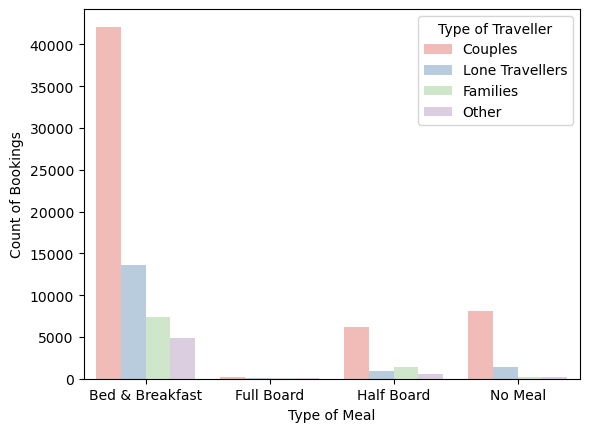

In [27]:
sns.countplot(data=df1,x = 'meal', hue= 'traveller_type')
plt.xlabel('Type of Meal')
plt.ylabel('Count of Bookings')
plt.legend(title = 'Type of Traveller', labels= ['Couples', 'Lone Travellers', 'Families', 'Other'])

Resort bookings account for 39% of bookings, whilst city bookings account for 61%


([<matplotlib.patches.Wedge at 0x7bec612a0d30>,
 [Text(0.37261175878219294, 1.0349688291041625, 'Resort Bookings'),
  Text(-0.37261175878219355, -1.0349688291041623, 'City Bookings')],
 [Text(0.2032427775175598, 0.564528452238634, '39%'),
  Text(-0.20324277751756012, -0.5645284522386339, '61%')])

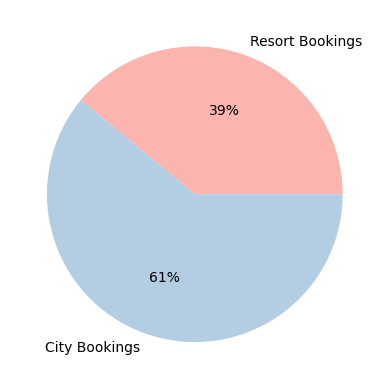

In [21]:
#resort hotels have had more lone travellers and families staying, 
#what is the percentage of resort hotel booking compared to hotel booking? 
total_booking = len(df1['hotel'])
resort_booking = round(len(df1[df1['hotel']== 'Resort Hotel']) / total_booking * 100)
city_booking = round(len(df1[df1['hotel']== 'City Hotel']) / total_booking *  100)
print(f'Resort bookings account for {resort_booking}% of bookings, whilst city bookings account for {city_booking}%')

plt.pie([resort_booking, city_booking], labels=['Resort Bookings', 'City Bookings'], autopct='%.0f%%')

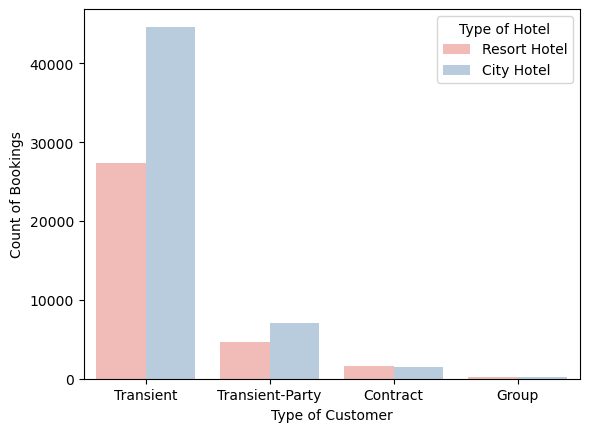

In [28]:
df1['customer_type'].unique()
sns.countplot(data=df1, x='customer_type', order= df1['customer_type'].value_counts().index, hue='hotel')
plt.xlabel('Type of Customer')
plt.ylabel('Count of Bookings')
plt.legend(title = 'Type of Hotel')
#we can see that the majority of bookings are transient, meaning most bookings would be shorter stays. 

Text(0, 0.5, 'Average amount of nights')

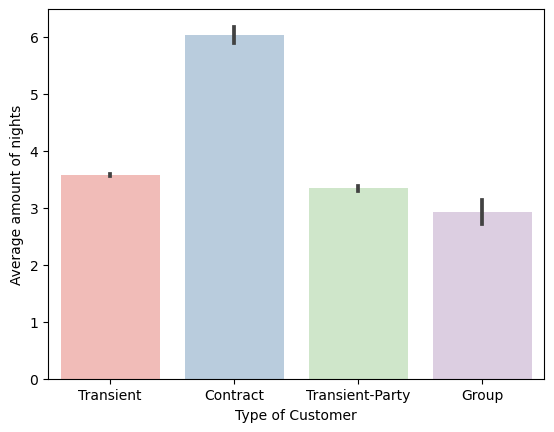

In [29]:
sns.barplot(data=df1,x='customer_type', y='total_nights')
plt.xlabel('Type of Customer')
plt.ylabel('Average amount of nights')

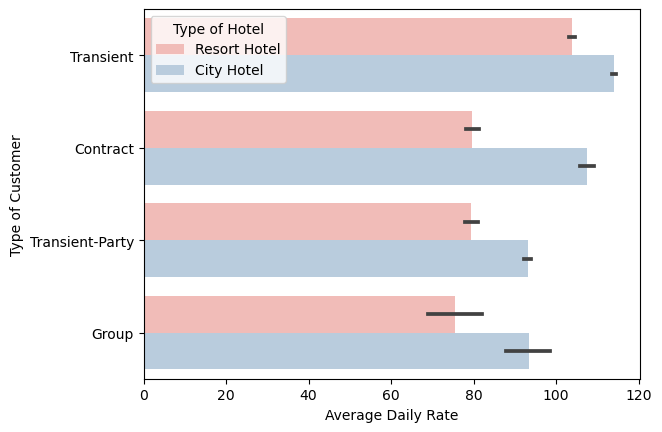

In [30]:
sns.barplot(data = df1, x= 'Average Daily Rate', y ='customer_type', hue='hotel')
plt.ylabel('Type of Customer')
plt.legend(title = 'Type of Hotel')
#Transient booking tend to be more expensive, Discounts may have been given for contracts and group bookings. City hotels seem to be more expensive than Resort hotels. 

In [25]:
top_10_country = df1['country'].value_counts().sort_values(ascending=False).head(10)
top_10_country

#Portugal is ahead of all european country with more than double the amount of the second country with the most bookings

PRT    27449
GBR    10432
FRA     8837
ESP     7252
DEU     5387
ITA     3066
IRL     3016
BEL     2081
BRA     1995
NLD     1911
Name: country, dtype: int64

# **Conclusion**

After exploring our data, we come to the following conclusions:
* Couples with no children seem to be booking hotels more than families or lone travellers.
* Couples and lone travellers tend to book under Bed & Breakfast, Full board is not a popular choice amongst travellers.
* There are more city bookings (61%) compared to resort bookings (39%).
* Transient bookings are the most common time, especially for city hotels.
* The amount of nights tends to be higher for contract customers.
* The average daily rate is higher for city hotel, transient customers pay more than others. 
* Portugal has the highest amount of bookings, followed by Great Britain and France. 